# NCR Population, Healthcare System, and Earthquake Catalog

## Declarations

In [1]:
from io import StringIO
from urllib.parse  import urlencode
import time

import requests
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import poisson
import folium
import plotly.express as px
import plotly.io as pio
from shapely.geometry import Point
import shapely.geometry
from getpass import getpass
from opencage.geocoder import OpenCageGeocode
import openrouteservice as ors

px.set_mapbox_access_token(open("../assets/.mapbox_token").read())
pio.renderers.default = 'notebook'

## Data Collection

### National Capital Region Population per Barangay

Source: https://psa.gov.ph/content/2020-census-population-and-housing-2020-cph-population-counts-declared-official-president

In [2]:
ncr_population = pd.read_csv("../data/raw/NCR_population.csv")

In [3]:
ncr_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        1710 non-null   object
 1   Barangay    1710 non-null   object
 2   Population  1710 non-null   object
dtypes: object(3)
memory usage: 40.2+ KB


In [5]:
ncr_population.head()

,City,Barangay,Population
0,Manila,Barangay 1,"2,995"
1,Manila,Barangay 2,"1,887"
2,Manila,Barangay 3,"1,341"
3,Manila,Barangay 4,"1,691"
4,Manila,Barangay 5,"1,288"


Renaming columns:

In [6]:
ncr_population.columns = ["city", "barangay", "population"]

Transforming barangay and city names to lowercase for consistency:

In [8]:
ncr_population['barangay'] = ncr_population['barangay'].str.lower()
ncr_population['city'] = ncr_population['city'].str.lower()

Converting population to int data type:

In [9]:
ncr_population['population'] = ncr_population['population'].apply(lambda x: int(''.join(x.split(','))))

In [10]:
ncr_population.head()

,city,barangay,population
0,manila,barangay 1,2995
1,manila,barangay 2,1887
2,manila,barangay 3,1341
3,manila,barangay 4,1691
4,manila,barangay 5,1288


Renaming barangay names to be consistent with the barangay boundaries dataset:

In [11]:
brgy_names = {"tañong (pob.)":"tañong", "marikina heights (concepcion)":"marikina heights",
              "santa elena (pob.)":"santa elena", "north bay boulevard north":"north bay blvd., north", 
              "san jose (pob.)":"san jose", "san nicolas (pob.)":"san nicolas", "new era":"constitution hills", 
              "santo domingo (matalahib)":"matalahib", "n. s. amoranto (gintong silahis)":"n.s. amoranto", 
              "pasong putik proper (pasong putik)":"pasong putik proper", "halo-halo (st. joseph)":"halo-halo", 
              "tanyag (bagong tanyag)":"bagong tanyag", "south signal village":"signal village", 
              "canumay west (canumay)":"canumay",
}

ncr_population['barangay'] = ncr_population['barangay'].apply(
    lambda x: brgy_names[x] 
    if any(brgy in x for brgy in brgy_names.keys()) 
    else x)

Adding population of barangays to be consistent with the barangay boundaries dataset:

In [12]:
# north bay blvd., south

population = ncr_population[(ncr_population['barangay'] == 'nbbs kaunlaran') | 
                            (ncr_population['barangay'] == 'nbbs proper') |
                            (ncr_population['barangay'] == 'nbbs dagat-dagatan')].population.sum()

row = pd.DataFrame({'city':['navotas'], 'barangay':['north bay blvd., south'], 'population':[population]})
ncr_population = pd.concat([ncr_population, row], ignore_index=True)

In [13]:
# tangos

population = ncr_population[(ncr_population['barangay'] == 'tangos south') | 
                            (ncr_population['barangay'] == 'tangos north')].population.sum()

row = pd.DataFrame({'city':['navotas'], 'barangay':['tangos'], 'population':[population]})
ncr_population = pd.concat([ncr_population, row], ignore_index=True)

In [14]:
# tanza

population = ncr_population[(ncr_population['barangay'] == 'tanza 1') | 
                            (ncr_population['barangay'] == 'tanza 2')].population.sum()

row = pd.DataFrame({'city':['navotas'], 'barangay':['tanza'], 'population':[population]})
ncr_population = pd.concat([ncr_population, row], ignore_index=True)

In [15]:
index_drop = ncr_population[(ncr_population['barangay'] == 'nbbs kaunlaran') | 
                            (ncr_population['barangay'] == 'nbbs proper') |
                            (ncr_population['barangay'] == 'nbbs dagat-dagatan') |
                            (ncr_population['barangay'] == 'tangos south') |
                            (ncr_population['barangay'] == 'tangos north') |
                            (ncr_population['barangay'] == 'tanza 1') |
                            (ncr_population['barangay'] == 'tanza 2')].index

ncr_population = ncr_population.drop(index_drop)
ncr_population = ncr_population.reset_index(drop=True)

In [16]:
ncr_population.head()

,city,barangay,population
0,manila,barangay 1,2995
1,manila,barangay 2,1887
2,manila,barangay 3,1341
3,manila,barangay 4,1691
4,manila,barangay 5,1288


In [17]:
ncr_population.shape

(1706, 3)

Reviewing barangay count per city:

In [18]:
ncr_population.city.value_counts()

manila         897
pasay          201
caloocan       188
quezon city    142
valenzuela      33
makati          33
pasig           30
taguig          28
mandaluyong     27
malabon         21
san juan        21
las pinas       20
paranaque       16
marikina        16
navotas         14
pateros         10
muntinlupa       9
Name: city, dtype: int64

## National Capital Region Barangay Boundaries

### Philippine administrative boundaries

Source: https://www.diva-gis.org/Data

In [19]:
ph_shp = gpd.read_file("../data/raw/PHL_adm3.shp")

In [20]:
ph_shp.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry
0,179,PHL,Philippines,1,Abra,1,Bangued,1,Agtangao,Barangay,Village,NaN,NaN,"POLYGON ((120.63702 17.56270, 120.63690 17.560..."
1,179,PHL,Philippines,1,Abra,1,Bangued,2,Angad,Barangay,Village,NaN,NaN,"POLYGON ((120.62151 17.57671, 120.62351 17.595..."
2,179,PHL,Philippines,1,Abra,1,Bangued,3,Bañacao,Barangay,Village,NaN,NaN,"POLYGON ((120.59573 17.60569, 120.58296 17.599..."
3,179,PHL,Philippines,1,Abra,1,Bangued,4,Bangbangar,Barangay,Village,NaN,NaN,"POLYGON ((120.60975 17.60699, 120.60423 17.600..."
4,179,PHL,Philippines,1,Abra,1,Bangued,5,Cabuloan,Barangay,Village,NaN,NaN,"POLYGON ((120.61269 17.59633, 120.61466 17.595..."


Plot of barangay boundaries:

<AxesSubplot:>

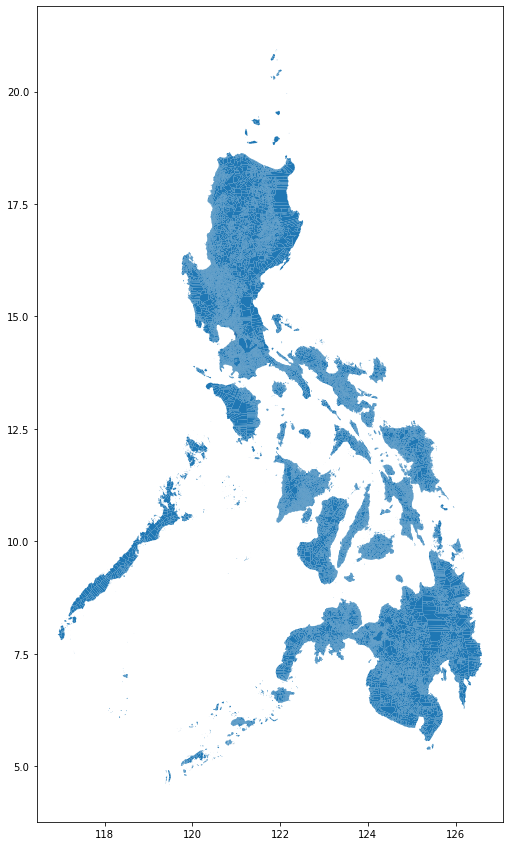

In [21]:
ph_shp.plot(figsize=(15,15))

Reviewing regions to isolate Metro Manila:

In [22]:
ph_shp.NAME_1.unique()

array(['Abra', 'Agusan del Norte', 'Agusan del Sur', 'Aklan', 'Albay',
       'Antique', 'Apayao', 'Aurora', 'Basilan', 'Bataan', 'Batanes',
       'Batangas', 'Benguet', 'Biliran', 'Bohol', 'Bukidnon', 'Bulacan',
       'Cagayan', 'Camarines Norte', 'Camarines Sur', 'Camiguin', 'Capiz',
       'Catanduanes', 'Cavite', 'Cebu', 'Compostela Valley',
       'Davao del Norte', 'Davao del Sur', 'Davao Oriental',
       'Dinagat Islands', 'Eastern Samar', 'Guimaras', 'Ifugao',
       'Ilocos Norte', 'Ilocos Sur', 'Iloilo', 'Isabela', 'Kalinga',
       'La Union', 'Laguna', 'Lanao del Norte', 'Lanao del Sur', 'Leyte',
       'Maguindanao', 'Marinduque', 'Masbate', 'Metropolitan Manila',
       'Misamis Occidental', 'Misamis Oriental', 'Mountain Province',
       'Negros Occidental', 'Negros Oriental', 'North Cotabato',
       'Northern Samar', 'Nueva Ecija', 'Nueva Vizcaya',
       'Occidental Mindoro', 'Oriental Mindoro', 'Palawan', 'Pampanga',
       'Pangasinan', 'Quezon', 'Quirino', 'Riza

### National Capital Region  administrative boundaries

Isolating boundaries for NCR:

In [24]:
mm_shp = ph_shp[ph_shp["NAME_1"] == "Metropolitan Manila"]

In [25]:
mm_shp.info() #population dataset has 1710 rows

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1691 entries, 24346 to 26036
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID_0       1691 non-null   int64   
 1   ISO        1691 non-null   object  
 2   NAME_0     1691 non-null   object  
 3   ID_1       1691 non-null   int64   
 4   NAME_1     1691 non-null   object  
 5   ID_2       1691 non-null   int64   
 6   NAME_2     1691 non-null   object  
 7   ID_3       1691 non-null   int64   
 8   NAME_3     1691 non-null   object  
 9   TYPE_3     1691 non-null   object  
 10  ENGTYPE_3  1691 non-null   object  
 11  NL_NAME_3  0 non-null      float64 
 12  VARNAME_3  5 non-null      object  
 13  geometry   1691 non-null   geometry
dtypes: float64(1), geometry(1), int64(4), object(8)
memory usage: 198.2+ KB


In [26]:
mm_shp.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry
24346,179,PHL,Philippines,47,Metropolitan Manila,961,Kalookan City,24347,Barangay 100,Barangay,Village,NaN,NaN,"POLYGON ((120.99181 14.65265, 120.99107 14.653..."
24347,179,PHL,Philippines,47,Metropolitan Manila,961,Kalookan City,24348,Barangay 101,Barangay,Village,NaN,NaN,"POLYGON ((120.99307 14.65218, 120.99255 14.650..."
24348,179,PHL,Philippines,47,Metropolitan Manila,961,Kalookan City,24349,Barangay 102,Barangay,Village,NaN,NaN,"POLYGON ((120.99228 14.64971, 120.99199 14.649..."
24349,179,PHL,Philippines,47,Metropolitan Manila,961,Kalookan City,24350,Barangay 103,Barangay,Village,NaN,NaN,"POLYGON ((120.98585 14.64703, 120.98582 14.648..."
24350,179,PHL,Philippines,47,Metropolitan Manila,961,Kalookan City,24351,Barangay 104,Barangay,Village,NaN,NaN,"POLYGON ((120.98439 14.64707, 120.98434 14.648..."


Renaming and dropping columns of the dataset:

In [27]:
mm_shp.columns

Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'ID_2', 'NAME_2', 'ID_3',
       'NAME_3', 'TYPE_3', 'ENGTYPE_3', 'NL_NAME_3', 'VARNAME_3', 'geometry'],
      dtype='object')

In [28]:
mm_shp = mm_shp.drop(columns = ['ID_0', 'ISO', 'NAME_0', 'ID_1', 'ID_2', 'ID_3', 'TYPE_3', 'ENGTYPE_3', 
                                'NL_NAME_3', 'VARNAME_3'])
mm_shp.columns = ["region", "city", "barangay", "geometry"]
mm_shp = mm_shp.reset_index(drop=True)

In [29]:
mm_shp

,region,city,barangay,geometry
0,Metropolitan Manila,Kalookan City,Barangay 100,"POLYGON ((120.99181 14.65265, 120.99107 14.653..."
1,Metropolitan Manila,Kalookan City,Barangay 101,"POLYGON ((120.99307 14.65218, 120.99255 14.650..."
2,Metropolitan Manila,Kalookan City,Barangay 102,"POLYGON ((120.99228 14.64971, 120.99199 14.649..."
3,Metropolitan Manila,Kalookan City,Barangay 103,"POLYGON ((120.98585 14.64703, 120.98582 14.648..."
4,Metropolitan Manila,Kalookan City,Barangay 104,"POLYGON ((120.98439 14.64707, 120.98434 14.648..."
...,...,...,...,...
1686,Metropolitan Manila,Valenzuela,Rincon,"POLYGON ((120.95284 14.69816, 120.95277 14.698..."
1687,Metropolitan Manila,Valenzuela,Tagalag,"POLYGON ((120.93951 14.72433, 120.93942 14.724..."
1688,Metropolitan Manila,Valenzuela,Ugong,"POLYGON ((121.01407 14.68327, 121.01405 14.683..."
1689,Metropolitan Manila,Valenzuela,Viente Reales,"POLYGON ((120.97729 14.70396, 120.97539 14.704..."


Making city names consistent with population dataset:

In [31]:
mm_shp.city.unique() #not consistent with the population dataset

array(['Kalookan City', 'Las Piñas', 'Makati City', 'Malabon',
       'Mandaluyong', 'Manila', 'Marikina', 'Muntinlupa', 'Navotas',
       'Parañaque', 'Pasay City', 'Pasig City', 'Pateros', 'Quezon City',
       'San Juan', 'Taguig', 'Valenzuela'], dtype=object)

In [30]:
# making city names consistent with the population dataset

mm_cities = {'Pasay City':'pasay', 'Kalookan City':'caloocan', 'Makati City':'makati', 'Pasig City':'pasig',
            'Las Piñas': 'las pinas', 'Parañaque':'paranaque'}

mm_shp['city'] = mm_shp['city'].apply(
    lambda x: mm_cities[x] 
    if any(city in x for city in mm_cities.keys()) 
    else x.lower())

In [31]:
mm_shp.city.value_counts()

manila         897
pasay          202
caloocan       188
quezon city    141
valenzuela      32
makati          32
pasig           30
mandaluyong     27
las pinas       21
malabon         20
san juan        20
taguig          18
paranaque       16
marikina        14
navotas         14
pateros         10
muntinlupa       9
Name: city, dtype: int64

Lowercasing barangay names for consistency:

In [32]:
mm_shp['barangay'] = mm_shp['barangay'].str.lower()

In [33]:
mm_shp

,region,city,barangay,geometry
0,Metropolitan Manila,caloocan,barangay 100,"POLYGON ((120.99181 14.65265, 120.99107 14.653..."
1,Metropolitan Manila,caloocan,barangay 101,"POLYGON ((120.99307 14.65218, 120.99255 14.650..."
2,Metropolitan Manila,caloocan,barangay 102,"POLYGON ((120.99228 14.64971, 120.99199 14.649..."
3,Metropolitan Manila,caloocan,barangay 103,"POLYGON ((120.98585 14.64703, 120.98582 14.648..."
4,Metropolitan Manila,caloocan,barangay 104,"POLYGON ((120.98439 14.64707, 120.98434 14.648..."
...,...,...,...,...
1686,Metropolitan Manila,valenzuela,rincon,"POLYGON ((120.95284 14.69816, 120.95277 14.698..."
1687,Metropolitan Manila,valenzuela,tagalag,"POLYGON ((120.93951 14.72433, 120.93942 14.724..."
1688,Metropolitan Manila,valenzuela,ugong,"POLYGON ((121.01407 14.68327, 121.01405 14.683..."
1689,Metropolitan Manila,valenzuela,viente reales,"POLYGON ((120.97729 14.70396, 120.97539 14.704..."


In [36]:
#mm_shp.to_file('mm_shp.geojson', driver='GeoJSON')

Reviewing barangay boundaries without name:

In [34]:
# barangay boundaries without name (cannot be merged with population data)

mm_shp[mm_shp['barangay'] == "n.a."]

,region,city,barangay,geometry
196,Metropolitan Manila,las pinas,n.a.,"POLYGON ((120.97972 14.49306, 120.98000 14.492..."
1184,Metropolitan Manila,manila,n.a.,"MULTIPOLYGON (((120.99085 14.56291, 120.99104 ..."
1212,Metropolitan Manila,navotas,n.a.,"POLYGON ((120.95728 14.64247, 120.95348 14.646..."
1439,Metropolitan Manila,pasay,n.a.,"POLYGON ((120.98922 14.55257, 120.98939 14.551..."
1550,Metropolitan Manila,quezon city,n.a.,"MULTIPOLYGON (((121.06779 14.66278, 121.06404 ..."


Plot of NCR barangay boundaries:

<AxesSubplot:>

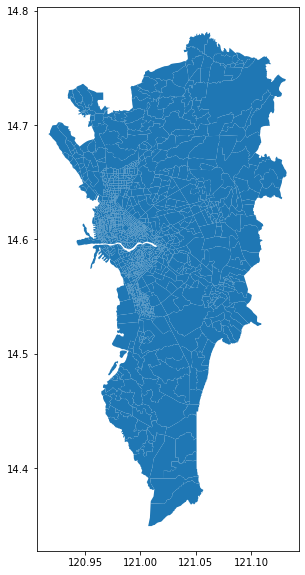

In [35]:
mm_shp.plot(figsize=(10,10))

## NCR Barangay population and boundary

In [36]:
ncr_boundary_pop = mm_shp.merge(ncr_population, on=["barangay", "city"], how='left')

In [37]:
ncr_boundary_pop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1691 entries, 0 to 1690
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   region      1691 non-null   object  
 1   city        1691 non-null   object  
 2   barangay    1691 non-null   object  
 3   geometry    1691 non-null   geometry
 4   population  1686 non-null   float64 
dtypes: float64(1), geometry(1), object(3)
memory usage: 79.3+ KB


Some boundaries cannot be merged with population dataset due to unnamed barangays:

In [38]:
ncr_boundary_pop[ncr_boundary_pop.population.isnull()]

,region,city,barangay,geometry,population
196,Metropolitan Manila,las pinas,n.a.,"POLYGON ((120.97972 14.49306, 120.98000 14.492...",NaN
1184,Metropolitan Manila,manila,n.a.,"MULTIPOLYGON (((120.99085 14.56291, 120.99104 ...",NaN
1212,Metropolitan Manila,navotas,n.a.,"POLYGON ((120.95728 14.64247, 120.95348 14.646...",NaN
1439,Metropolitan Manila,pasay,n.a.,"POLYGON ((120.98922 14.55257, 120.98939 14.551...",NaN
1550,Metropolitan Manila,quezon city,n.a.,"MULTIPOLYGON (((121.06779 14.66278, 121.06404 ...",NaN


In [39]:
ncr_boundary_pop = ncr_boundary_pop.fillna(0)

In [40]:
ncr_boundary_pop.head()

,region,city,barangay,geometry,population
0,Metropolitan Manila,caloocan,barangay 100,"POLYGON ((120.99181 14.65265, 120.99107 14.653...",983.0
1,Metropolitan Manila,caloocan,barangay 101,"POLYGON ((120.99307 14.65218, 120.99255 14.650...",2517.0
2,Metropolitan Manila,caloocan,barangay 102,"POLYGON ((120.99228 14.64971, 120.99199 14.649...",1033.0
3,Metropolitan Manila,caloocan,barangay 103,"POLYGON ((120.98585 14.64703, 120.98582 14.648...",175.0
4,Metropolitan Manila,caloocan,barangay 104,"POLYGON ((120.98439 14.64707, 120.98434 14.648...",899.0


<AxesSubplot:>

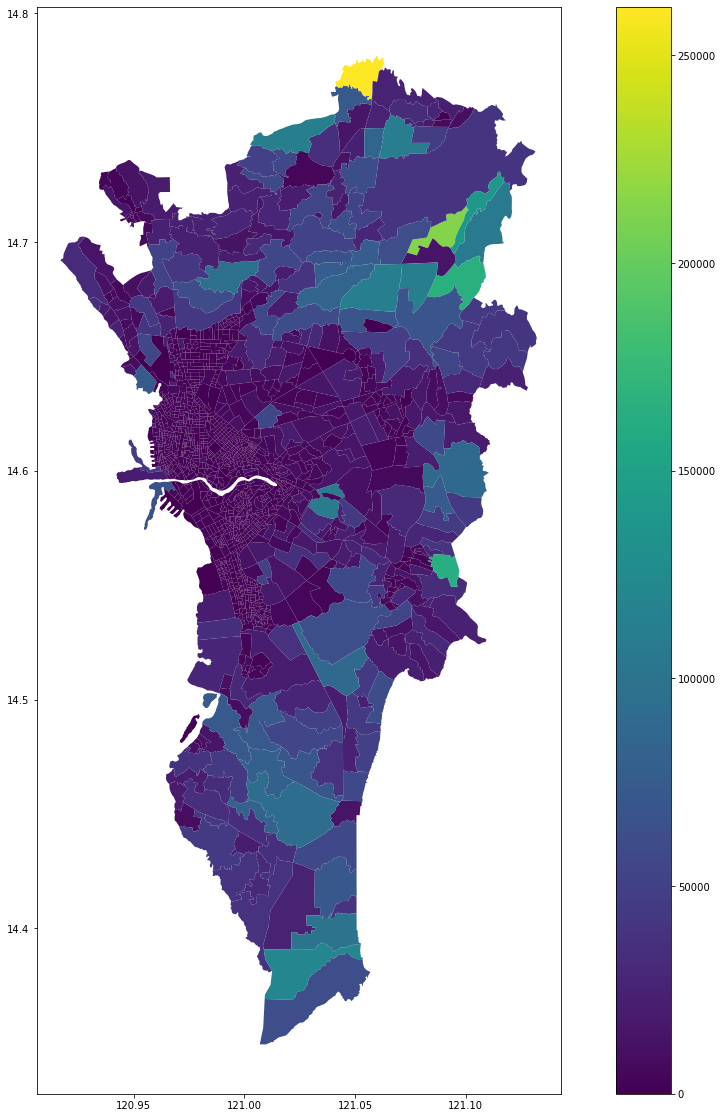

In [41]:
ncr_boundary_pop.plot(column="population", figsize=(20,20), legend=True)

## DOH hospital data

Source: https://nhfr.doh.gov.ph/VActivefacilitiesList

In [42]:
df_hosp = pd.read_csv("../data/raw/v_activefacilities.csv")

In [43]:
df_hosp.head(3)

,Health Facility Code,Health Facility Code Short,Facility Name,Old Health Facility Name 1,Old Health Facility Name 2,Old Health Facility Name 3,Facility Major Type,Health Facility Type,Ownership Major Classification,Ownership Sub-Classification for Government facilities,...,Landline Number,Landline Number 2,Fax Number,Email Address,Alternate Email Address,Official Website,Service Capability,Bed Capacity,Licensing Status,License Validity Date
0,DOH000000000005026,5026,A. ZARATE GENERAL HOSPITAL,NaN,NaN,NaN,Health Facility,Hospital,Private,NaN,...,+63 028746903,+63 028724827,+63 028724827,azarategeneralhospital@gmail.com,azarategeneralhospital91@gmail.com,NaN,Level 1,17,<b>Licensing Status:</b><br><span class=' btn-...,12/31/2023
1,DOH000000000004706,4706,ACEBEDO GENERAL HOSPITAL,NaN,NaN,NaN,Health Facility,Hospital,Private,NaN,...,+63 029835363,+63 024001272,+63 029835363,acebedogenhospital@yahoo.com,NaN,NaN,Level 1,16,<b>Licensing Status:</b><br><span class=' btn-...,12/31/2023
2,DOH000000000006034,6034,ADVENTIST MEDICAL CENTER MANILA,"ADVENTIST MEDICAL CENTER, INC.",MANILA SANITARIUM HOSPITAL,"MANILA ADVENTIST MEDICAL CENTER AND COLLEGES, ...",Health Facility,Hospital,Private,NaN,...,+63 025259191,NaN,+63 025243256,info@amcmanila.org,NaN,NaN,Level 3,150,<b>Licensing Status:</b><br><span class=' btn-...,NaN


In [44]:
df_hosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 32 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Health Facility Code                                    155 non-null    object 
 1   Health Facility Code Short                              155 non-null    int64  
 2   Facility Name                                           155 non-null    object 
 3   Old Health Facility Name 1                              41 non-null     object 
 4   Old Health Facility Name 2                              5 non-null      object 
 5   Old Health Facility Name 3                              1 non-null      object 
 6   Facility Major Type                                     155 non-null    object 
 7   Health Facility Type                                    155 non-null    object 
 8   Ownership Major Classification          

In [45]:
df_hosp.columns

Index(['Health Facility Code', 'Health Facility Code Short', 'Facility Name',
       'Old Health Facility Name 1', 'Old Health Facility Name 2',
       'Old Health Facility Name 3', 'Facility Major Type',
       'Health Facility Type', 'Ownership Major Classification',
       'Ownership Sub-Classification for Government facilities',
       'Ownership Sub-Classification for private facilities',
       'Street Name and #', 'Building name and #', 'Region Name',
       'Region PSGC', 'Province Name', 'Province PSGC',
       'City/Municipality Name', 'City/Municipality PSGC', 'Barangay Name',
       'Barangay PSGC', 'Zip Code', 'Landline Number', 'Landline Number 2',
       'Fax Number', 'Email Address', 'Alternate Email Address',
       'Official Website', 'Service Capability', 'Bed Capacity',
       'Licensing Status', 'License Validity Date'],
      dtype='object')

In [46]:
df_hosp = df_hosp.drop(columns=['Health Facility Code', 'Health Facility Code Short', 'Old Health Facility Name 1', 
                      'Old Health Facility Name 2','Old Health Facility Name 3', 'Facility Major Type', 
                      'Ownership Major Classification','Ownership Sub-Classification for Government facilities',
                      'Ownership Sub-Classification for private facilities', 'Building name and #', 'Region PSGC', 
                      'Province PSGC', 'City/Municipality PSGC', 'Barangay PSGC', 'Zip Code', 'Landline Number', 
                      'Landline Number 2','Fax Number', 'Email Address', 'Alternate Email Address','Official Website', 
                      'Licensing Status', 'License Validity Date'])

In [47]:
df_hosp.columns = ["facility_name", "facility_type", "street", "region", "district", "city", "barangay", 
                          "service_capability", "bed_capacity",]

In [48]:
df_hosp.head()

,facility_name,facility_type,street,region,district,city,barangay,service_capability,bed_capacity
0,A. ZARATE GENERAL HOSPITAL,Hospital,ATLAS COMPOUND NAGA ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF LAS PI?AS,PULANG LUPA DOS,Level 1,17
1,ACEBEDO GENERAL HOSPITAL,Hospital,"849 GEN. LUIS STREET, BAGBAGUIN",NATIONAL CAPITAL REGION (NCR),"NCR, THIRD DISTRICT (NOT A PROVINCE)",CITY OF CALOOCAN,BARANGAY 175,Level 1,16
2,ADVENTIST MEDICAL CENTER MANILA,Hospital,1975 DONADA STREET,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 35,Level 3,150
3,AIR FORCE GENERAL HOSPITAL,Hospital,COL. JESUS VILLAMOR AIR BASE,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 183,Level 2,100
4,ALABANG MEDICAL CENTER,Hospital,ALABANG-ZAPOTE ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF MUNTINLUPA,ALABANG,Level 1,18


#### Obtain hospital coordinates using OpenCage GeoCoding API

OpenCage documentation: https://opencagedata.com/tutorials/geocode-in-python

In [511]:
key = getpass("Enter API key: ")
geocoder = OpenCageGeocode(key)

def get_coords(facility_name):
    query = u'{}'.format(facility_name)
    results = geocoder.geocode(query)
    if results:
        if results[0]['components']['country'] == 'Philippines':
            return (results[0]['geometry']['lng'], results[0]['geometry']['lat'])
    return
    

Enter API key: ········


In [519]:
df_hosp['coordinates'] = df_hosp['facility_name'].apply(lambda x: get_coords(x))

In [520]:
df_hosp

,facility_name,facility_type,street,region,district,city,barangay,service_capability,bed_capacity,coordinates
0,A. ZARATE GENERAL HOSPITAL,Hospital,ATLAS COMPOUND NAGA ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF LAS PI?AS,PULANG LUPA DOS,Level 1,17,None
1,ACEBEDO GENERAL HOSPITAL,Hospital,"849 GEN. LUIS STREET, BAGBAGUIN",NATIONAL CAPITAL REGION (NCR),"NCR, THIRD DISTRICT (NOT A PROVINCE)",CITY OF CALOOCAN,BARANGAY 175,Level 1,16,None
2,ADVENTIST MEDICAL CENTER MANILA,Hospital,1975 DONADA STREET,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 35,Level 3,150,"(120.9952699, 14.555952)"
3,AIR FORCE GENERAL HOSPITAL,Hospital,COL. JESUS VILLAMOR AIR BASE,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 183,Level 2,100,"(121.0200055, 14.5168894)"
4,ALABANG MEDICAL CENTER,Hospital,ALABANG-ZAPOTE ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF MUNTINLUPA,ALABANG,Level 1,18,"(121.0244792, 14.4277653)"
5,ALABANG MEDICAL CLINIC,Hospital,297 T. MONTILLANO STREET,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF MUNTINLUPA,ALABANG,Level 1,18,"(121.0499702, 14.4192377)"
6,ALABANG MEDICAL CLINIC - LAS PIÑAS BRANCH,Hospital,ALABANG-ZAPOTE RD. COR. MENDOZA ST. PELAYO VIL...,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF LAS PI?AS,TALON UNO,Level 1,18,None
7,ALABANG MEDICAL CLINIC - MUNTINLUPA BRANCH,Hospital,1 NATIONAL ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF MUNTINLUPA,PUTATAN,Level 1,25,None
8,ALFONSO SPECIALIST HOSPITAL,Hospital,185 DR. SIXTO ANTONIO AVENUE,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (NOT A PROVINCE)",CITY OF PASIG,ROSARIO,Level 1,22,"(121.0846475, 14.5901099)"
9,ALLIED CARE EXPERTS (ACE) MEDICAL CENTER - PAT...,Hospital,884 P. HERRERA STREET,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PATEROS,AGUHO,Level 2,58,None


In [521]:
#df_hosp.to_csv("hospital_coords.csv")

Missing coordinates where manually obtained from google maps.

In [49]:
ncr_hosp = pd.read_csv("../data/transformed/hospital_coords.csv", index_col=0)

In [50]:
ncr_hosp.head()

,facility_name,facility_type,street,region,district,city,barangay,service_capability,bed_capacity,coordinates
0,A. ZARATE GENERAL HOSPITAL,Hospital,ATLAS COMPOUND NAGA ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF LAS PI?AS,PULANG LUPA DOS,Level 1,17,"(120.980515915737, 14.4690104246232)"
1,ACEBEDO GENERAL HOSPITAL,Hospital,"849 GEN. LUIS STREET, BAGBAGUIN",NATIONAL CAPITAL REGION (NCR),"NCR, THIRD DISTRICT (NOT A PROVINCE)",CITY OF CALOOCAN,BARANGAY 175,Level 1,16,"(121.005092590193, 14.7187700341626)"
2,ADVENTIST MEDICAL CENTER MANILA,Hospital,1975 DONADA STREET,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 35,Level 3,150,"(120.9952699, 14.555952)"
3,AIR FORCE GENERAL HOSPITAL,Hospital,COL. JESUS VILLAMOR AIR BASE,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 183,Level 2,100,"(121.0200055, 14.5168894)"
4,ALABANG MEDICAL CENTER,Hospital,ALABANG-ZAPOTE ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF MUNTINLUPA,ALABANG,Level 1,18,"(121.0244792, 14.4277653)"


#### Generate GeoDataframe for the hospitals:

In [51]:
ncr_hosp['coordinates'] = ncr_hosp['coordinates'].apply(lambda x: tuple(map(float, x.strip('()').split(','))))

In [52]:
geometry = [Point(xy) for xy in ncr_hosp['coordinates']]

In [53]:
ncr_hosp = gpd.GeoDataFrame(ncr_hosp, geometry=geometry, crs="EPSG:4326")

In [54]:
ncr_hosp = ncr_hosp.drop(columns = ['coordinates'])

In [55]:
ncr_hosp

,facility_name,facility_type,street,region,district,city,barangay,service_capability,bed_capacity,geometry
0,A. ZARATE GENERAL HOSPITAL,Hospital,ATLAS COMPOUND NAGA ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF LAS PI?AS,PULANG LUPA DOS,Level 1,17,POINT (120.98052 14.46901)
1,ACEBEDO GENERAL HOSPITAL,Hospital,"849 GEN. LUIS STREET, BAGBAGUIN",NATIONAL CAPITAL REGION (NCR),"NCR, THIRD DISTRICT (NOT A PROVINCE)",CITY OF CALOOCAN,BARANGAY 175,Level 1,16,POINT (121.00509 14.71877)
2,ADVENTIST MEDICAL CENTER MANILA,Hospital,1975 DONADA STREET,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 35,Level 3,150,POINT (120.99527 14.55595)
3,AIR FORCE GENERAL HOSPITAL,Hospital,COL. JESUS VILLAMOR AIR BASE,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",PASAY CITY,BARANGAY 183,Level 2,100,POINT (121.02001 14.51689)
4,ALABANG MEDICAL CENTER,Hospital,ALABANG-ZAPOTE ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, FOURTH DISTRICT (NOT A PROVINCE)",CITY OF MUNTINLUPA,ALABANG,Level 1,18,POINT (121.02448 14.42777)
...,...,...,...,...,...,...,...,...,...,...
150,VICTORIANO LUNA MEDICAL CENTER,Hospital,V. LUNA ROAD,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (NOT A PROVINCE)",QUEZON CITY,PINYAHAN,Level 3,"1,200",POINT (121.05251 14.63483)
151,"VILLAROSA HOSPITAL, INC.",Hospital,11 SALALILLA STREET PROJ 4,NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (NOT A PROVINCE)",QUEZON CITY,MILAGROSA,Level 1,10,POINT (121.06620 14.62196)
152,"VILLON-TANSINSIN HOSPITAL, INC.",Hospital,"3 TOYOTA AVENUE, CORNER GUERILLA STREET STO. NINO",NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (NOT A PROVINCE)",CITY OF MARIKINA,SANTO NI?O,Level 1,20,POINT (121.09947 14.63728)
153,"WORD OF HOPE GENERAL HOSPITAL FOUNDATION, INC.",Hospital,"23 BUENAMAR STREET, BUENAMAR SUBDIVISION",NATIONAL CAPITAL REGION (NCR),"NCR, SECOND DISTRICT (NOT A PROVINCE)",QUEZON CITY,NOVALICHES PROPER,Level 1,30,POINT (121.03902 14.71930)


Plot of hospitals and centroid of barangay boundaries:


C:\conda_tmp\ipykernel_40524\3230846356.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mm_shp.centroid.plot(ax=base, color="yellow", markersize=10)


<AxesSubplot:>

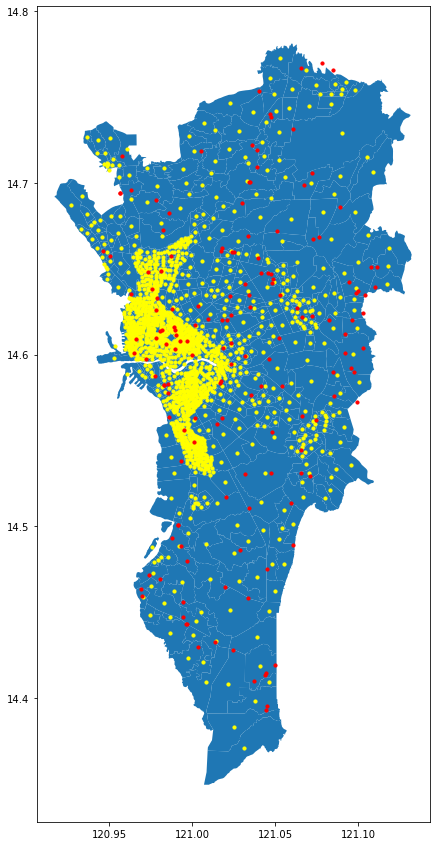

In [56]:
base = mm_shp.plot(figsize=(15,15))
mm_shp.centroid.plot(ax=base, color="yellow", markersize=10)
ncr_hosp.plot(ax=base, color="red", markersize=10)

### Travel Matrix Dataset using OpenRouteService API

API documentation: https://openrouteservice-py.readthedocs.io/en/latest/

In [57]:
client = ors.Client(key=getpass("Enter API key: "))

Enter API key: ········


In [53]:
ncr_centroids = list(mm_shp.centroid.apply(lambda coords: [coords.x, coords.y]))

C:\conda_tmp\ipykernel_32704\2823257964.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ncr_centroids = list(mm_shp.centroid.apply(lambda coords: [coords.x, coords.y]))


In [59]:
len(ncr_centroids) #0-1690 index

1691

In [60]:
hosp_points = list(ncr_hosp.geometry.apply(lambda coords: [coords.x, coords.y]))

In [61]:
len(hosp_points) #1691-1845 index

155

In [62]:
travel_coords = ncr_centroids
travel_coords.extend(hosp_points)

In [105]:
len(travel_coords)

1846

Calculate travel time from each barangay to hospital pair:


**Note**: The API call shown below is only for one barangay 

In [98]:
#Initialize dataframe
travel_matrix = pd.DataFrame(columns=["brgy_index","hosp_index","duration"])

#Subset the number of barangays into three to avoid API rate limit
batch_1_source = [x for x in range(0,570)] #570 API rate limit
batch_2_source = [x for x in range (570,1140)]
batch_3_source = [x for x in range (1140,1691)]
brgy_source = [batch_1_source, batch_2_source, batch_3_source]

#trial of one hospital
hosp_dest = [x for x in range(1691,1692)] 

#Uncomment code below to run for all hospitals
#hosp_dest = [x for x in range(1691,1846)] 

In [100]:
for hosp_index in hosp_dest:
    for batch in brgy_source:
        time.sleep(2) #40 requests per min
        
        mm_travel_matrix = client.distance_matrix(
            locations=travel_coords,
            profile='driving-car',
            sources=batch,
            destinations=[hosp_index],
            metrics=['duration'],
        )
        
        row = pd.DataFrame({"brgy_index":[batch], "hosp_index":[hosp_index], 
                            "duration":[mm_travel_matrix['durations']]})
        travel_matrix = pd.concat([travel_matrix, row], ignore_index=True)

In [104]:
travel_matrix

,brgy_index,hosp_index,duration
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1691,"[[2367.47], [2271.67], [2263.77], [2230.33], [..."
1,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1691,"[[1981.14], [1992.38], [1929.39], [1991.11], [..."
2,"[1140, 1141, 1142, 1143, 1144, 1145, 1146, 114...",1691,"[[1641.18], [1682.33], [1981.24], [1834.27], [..."


Show all calculated travel times for each barangay and hospital pair:

In [91]:
travel_matrix = pd.read_csv("../data/raw/travel_matrix.csv", index_col=0)

In [92]:
travel_matrix

,brgy_index,hosp_index,duration
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1691,"[[2367.47], [2271.67], [2263.77], [2230.33], [..."
1,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1691,"[[1981.14], [1992.38], [1929.39], [1991.11], [..."
2,"[1140, 1141, 1142, 1143, 1144, 1145, 1146, 114...",1691,"[[1641.18], [1682.33], [1981.24], [1834.27], [..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1692,"[[848.44], [889.44], [888.67], [918.5], [936.8..."
4,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1692,"[[1099.01], [1099.62], [1123.56], [1091.32], [..."
...,...,...,...
460,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1844,"[[1442.77], [1443.38], [1467.32], [1435.08], [..."
461,"[1140, 1141, 1142, 1143, 1144, 1145, 1146, 114...",1844,"[[1932.1], [2012.25], [2089.01], [1681.48], [1..."
462,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1845,"[[1069.61], [1094.75], [1093.98], [1125.71], [..."
463,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1845,"[[1165.51], [1135.75], [1117.18], [1093.63], [..."


## Earthquake Dataset from United States Geological Survey (USGS)

Source: https://earthquake.usgs.gov/fdsnws/event/1/

In [2]:
_format = "csv"
starttime = "1900-0-0"
endtime = "2023-10-03"
maxradiuskm = "500"
latitude = "14.5826" #luneta
longitude = "120.9787"
minmagnitude = "5.0"
orderby = "time"
params = {"format":_format, 
          "starttime":starttime, 
          "endtime":endtime, 
          "maxradiuskm":maxradiuskm, 
         "latitude":latitude, 
          "longitude":longitude, 
          "minmagnitude":minmagnitude, 
          "orderby":orderby,
     }
url_params = urlencode(params)

In [3]:
endpoint = "https://earthquake.usgs.gov/fdsnws/event/1/query"
url = f"{endpoint}?{url_params}"
response = requests.get(url)

In [4]:
eq_data = StringIO(response.text)
eq_df = pd.read_csv(eq_data)

In [5]:
eq_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-06-15T02:19:23.272Z,13.7629,120.7203,112.000,6.2,mww,146.0,22.0,8.189,0.64,...,2023-08-21T04:18:57.040Z,"Mindoro, Philippines",earthquake,7.51,1.810,0.034,84.0,reviewed,us,us
1,2023-05-07T11:36:21.892Z,17.4838,122.3072,31.537,5.2,mww,110.0,41.0,5.430,0.51,...,2023-07-22T19:16:17.040Z,"45 km NNW of Dicabisagan, Philippines",earthquake,7.25,4.328,0.056,31.0,reviewed,us,us
2,2023-05-04T00:49:04.476Z,17.4696,122.3465,19.000,5.4,mww,235.0,51.0,5.452,0.65,...,2023-07-15T22:09:33.040Z,"Luzon, Philippines",earthquake,8.78,1.707,0.056,31.0,reviewed,us,us
3,2023-04-28T16:00:29.976Z,13.6644,120.6333,89.364,5.2,mww,88.0,72.0,8.161,0.94,...,2023-07-11T01:45:31.040Z,"18 km S of Calatagan, Philippines",earthquake,8.86,5.029,0.048,42.0,reviewed,us,us
4,2023-04-23T16:23:18.663Z,14.2645,118.9138,10.000,5.3,mww,73.0,51.0,9.167,0.70,...,2023-07-11T01:44:40.040Z,"129 km WNW of Cabra, Philippines",earthquake,9.03,1.849,0.059,28.0,reviewed,us,us


In [6]:
ncr_eq = eq_df[['latitude', 'longitude', 'mag', 'magType', 'time', 'place', 'depth']]

In [7]:
ncr_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1068 non-null   float64
 1   longitude  1068 non-null   float64
 2   mag        1068 non-null   float64
 3   magType    1068 non-null   object 
 4   time       1068 non-null   object 
 5   place      1068 non-null   object 
 6   depth      1068 non-null   float64
dtypes: float64(4), object(3)
memory usage: 58.5+ KB


In [8]:
ncr_eq.head()

,latitude,longitude,mag,magType,time,place,depth
0,13.7629,120.7203,6.2,mww,2023-06-15T02:19:23.272Z,"Mindoro, Philippines",112.000
1,17.4838,122.3072,5.2,mww,2023-05-07T11:36:21.892Z,"45 km NNW of Dicabisagan, Philippines",31.537
2,17.4696,122.3465,5.4,mww,2023-05-04T00:49:04.476Z,"Luzon, Philippines",19.000
3,13.6644,120.6333,5.2,mww,2023-04-28T16:00:29.976Z,"18 km S of Calatagan, Philippines",89.364
4,14.2645,118.9138,5.3,mww,2023-04-23T16:23:18.663Z,"129 km WNW of Cabra, Philippines",10.000


In [9]:
def magnitude_classifier(mag):
    if mag >= 5 and mag < 5.85:
        return 'A'
    elif mag >= 5.85 and mag < 6.45:
        return 'B'
    elif mag >= 6.45 and mag < 7.05:
        return 'C'
    elif mag >= 7.05 and mag < 7.65:
        return 'D'
    else:
        return 'E'

In [10]:
ncr_eq['maggroup'] = ncr_eq['mag'].map(magnitude_classifier)

C:\conda_tmp\ipykernel_20340\3946823470.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
ncr_eq.head()

,latitude,longitude,mag,magType,time,place,depth,maggroup
0,13.7629,120.7203,6.2,mww,2023-06-15T02:19:23.272Z,"Mindoro, Philippines",112.000,B
1,17.4838,122.3072,5.2,mww,2023-05-07T11:36:21.892Z,"45 km NNW of Dicabisagan, Philippines",31.537,A
2,17.4696,122.3465,5.4,mww,2023-05-04T00:49:04.476Z,"Luzon, Philippines",19.000,A
3,13.6644,120.6333,5.2,mww,2023-04-28T16:00:29.976Z,"18 km S of Calatagan, Philippines",89.364,A
4,14.2645,118.9138,5.3,mww,2023-04-23T16:23:18.663Z,"129 km WNW of Cabra, Philippines",10.000,A


Plot of Earthquakes:

In [113]:
#building site location
lat = 14.5826
long = 120.9787


#base map
folium_map = folium.Map(location=[lat, long],
                        zoom_start=7, max_zoom=15, min_zoom = 6,
                        tiles="openstreetmap")

#site location
folium.Marker(
        location=[lat, long],
        icon=folium.DivIcon(html=f"""
            <svg>
                <circle cx="30" cy="30" r="10" stroke="black" stroke-width="2" fill="#FD02FD" opacity="1"/>| 
            </svg>""")
    ).add_to(folium_map)

#Mapping earthquake records
for magtype, records in ncr_eq.groupby('maggroup'):
    
    feature_group = folium.FeatureGroup(magtype)
    
    for record in records.itertuples():
        r = 10
        if magtype == 'A':
            rad = r
            color = '#02FD74'
        elif magtype == 'B':
            rad = r*1.5
            color = '#DBFD02'
        elif magtype == 'C':
            rad = r*2
            color = '#FDCC02'
        elif magtype == 'D':
            rad = r*2.5
            color = '#FD7C02'
        elif magtype == 'E':
            rad = r*3 
            color = '#FD0202'

        folium.Marker(
                location=[record.latitude, record.longitude],
                tooltip =  'Mag = ' + str(record.mag),
                popup = folium.Popup(
                    'Time:' + str(record.time[:10]) + '\n' 
                    + 'Location: ' + str(record.place)[:-13] + '\n' 
                    + 'Depth: ' + str(round(record.depth,1)) + ' km', 
                    max_width = '90'),
                icon=folium.DivIcon(html=f"""
                    <svg>
                        <circle cx="30" cy="30" r={rad} stroke="black" stroke-width="1" fill={color} opacity="0.7"/>
                    </svg>""")
            ).add_to(feature_group)
    
    feature_group.add_to(folium_map)

#Layer Control for feature groups
folium.LayerControl().add_to(folium_map)

folium_map

#### Earthquake rate per year from 1900-2023

In [123]:
ncr_eq.head()

,latitude,longitude,mag,magType,time,place,depth,maggroup
0,13.7629,120.7203,6.2,mww,2023-06-15T02:19:23.272Z,"Mindoro, Philippines",112.000,B
1,17.4838,122.3072,5.2,mww,2023-05-07T11:36:21.892Z,"45 km NNW of Dicabisagan, Philippines",31.537,A
2,17.4696,122.3465,5.4,mww,2023-05-04T00:49:04.476Z,"Luzon, Philippines",19.000,A
3,13.6644,120.6333,5.2,mww,2023-04-28T16:00:29.976Z,"18 km S of Calatagan, Philippines",89.364,A
4,14.2645,118.9138,5.3,mww,2023-04-23T16:23:18.663Z,"129 km WNW of Cabra, Philippines",10.000,A


In [12]:
year_count = 123
eq_count = ncr_eq.shape[0]
eq_bins = np.arange(0,16,1)

mean_rate = eq_count / year_count

eq_rate = poisson.pmf(eq_bins, mean_rate)

In [13]:
eq_rate_df = pd.DataFrame({"no_eq":eq_bins, "p":eq_rate})

In [15]:
rate_fig = px.bar(eq_rate_df, 
                  x="no_eq", 
                  y="p", 
                  color="p", 
                  color_continuous_scale="Oranges",
                  range_color=(0, eq_rate_df.p.max()),
                  labels={
                      "no_eq": "No. of Significant Earthquakes per Year",}, 
                  height=300,
                  width=400)

rate_fig.update_layout(coloraxis_showscale=False, 
                  plot_bgcolor='white',)
rate_fig.update_layout(yaxis_visible=False, 
                   yaxis_showticklabels=False, 
                   xaxis=dict(dtick=2))
rate_fig.show()

## Philippine Fault Lines
Source: https://github.com/GEMScienceTools/gem-global-active-faults

In [16]:
fault_line = gpd.read_file('../data/raw/gem_active_faults.geojson',
                            driver='GeoJSON')

In [17]:
fault_line.head(3)

,accuracy,activity_confidence,average_dip,average_rake,catalog_id,catalog_name,dip_dir,downthrown_side_dir,downthrown_side_id,epistemic_quality,...,name,net_slip_rate,notes,reference,shortening_rate,slip_type,strike_slip_rate,upper_seis_depth,vert_sep_rate,geometry
0,NaN,NaN,"(38,,)","(90.0,,)",UCF_2,UCERF3,E,NaN,NaN,NaN,...,Mount Diablo Thrust,"(1.55,0.8,2.22)",NaN,NaN,NaN,Reverse,NaN,"(8.0,,)",NaN,"LINESTRING (-121.82290 37.73010, -122.03880 37..."
1,NaN,NaN,"(90,,)","(180.0,,)",UCF_9,UCERF3,NaN,NaN,NaN,NaN,...,Ortigalita (South),"(1.23,0.35,2.75)",NaN,NaN,NaN,Dextral,NaN,"(0.0,,)",NaN,"LINESTRING (-121.14290 37.10810, -121.13800 37..."
2,NaN,NaN,"(90,,)","(150.0,,)",UCF_11,UCERF3,NaN,NaN,NaN,NaN,...,Monterey Bay-Tularcitos,"(0.57,0.23,1.73)",NaN,NaN,NaN,Dextral,NaN,"(0.0,,)",NaN,"LINESTRING (-121.50309 36.35759, -121.59573 36..."


In [18]:
fault_line = fault_line.to_crs("EPSG:4326")

In [19]:
fault_line['catalog_name'].unique()

array(['UCERF3', 'AUS_FSD', 'Active Tectonics of the Andes',
       'Macgregor_AfricaFaults', 'EMME', 'GEM Faulted Earth', 'SHARE',
       'HimaTibetMap', 'philippines', 'SARA', 'USGS Hazfaults 2014',
       'Shyu Taiwan', 'Villegas Mexico', 'Bird 2003',
       'Litchfield_NZ_2013', 'EOS_SE_Asia', 'GEM_NE_Asia', 'GEM_N_Africa',
       'GEM_Central_Am_Carib', 'SMSSD'], dtype=object)

#### Philippine Boundary

In [20]:
ph_shp = gpd.read_file("../data/raw/PHL_adm0.shp")

In [21]:
ph_shp

,ID_0,ISO,NAME_0,OBJECTID_1,ISO3,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,...,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,geometry
0,179,PHL,Philippines,179,PHL,Philippines,PHILIPPINES,Philippines,Pilipinas,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((119.46694 4.58694, 119.46639 4..."


In [22]:
fault_lines_ph = gpd.sjoin(fault_line,
                               ph_shp,
                               how='inner',
                               predicate='intersects'
                              )

In [23]:
fault_lines_ph.shape

(118, 95)

In [24]:
fault_lines_ph.head(3)

,accuracy,activity_confidence,average_dip,average_rake,catalog_id,catalog_name,dip_dir,downthrown_side_dir,downthrown_side_id,epistemic_quality,...,CSN,CARICOM,EU,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC
8647,NaN,NaN,NaN,NaN,PHL_0,philippines,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8648,NaN,NaN,NaN,NaN,PHL_1,philippines,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8649,NaN,NaN,NaN,NaN,PHL_2,philippines,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
fault_lines_ph = fault_lines_ph.dropna(subset=['name'])

In [26]:
fault_lines_ph = fault_lines_ph[['name', 'geometry']].reset_index(drop=True)

In [27]:
fault_lines_ph.head()

,name,geometry
0,Colosas Fault,"LINESTRING (125.57053 7.42785, 125.51403 7.52689)"
1,Colosas Fault,"LINESTRING (125.57053 7.42785, 125.51403 7.52689)"
2,Dacudao Fault,"LINESTRING (125.43461 7.24751, 125.43475 7.242..."
3,Central Cebu Fault,"LINESTRING (123.95382 10.52186, 123.95131 10.5..."
4,East Negros Fault North,"LINESTRING (123.49640 10.72408, 123.49603 10.7..."


In [28]:
lats = []
lons = []
names = []

for feature, name in zip(fault_lines_ph.geometry, fault_lines_ph.name):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)
          
fault_fig = px.line_mapbox(
    lat=lats,
    lon=lons, 
    hover_name=names,
    color=len(names)*["fault line"],
    color_discrete_map={"fault line":"red"},
    mapbox_style="dark",
    center={'lat': 14.5826, 'lon': 120.9787},
    zoom=5,
    height=800,
)

fault_fig.update_traces(customdata= pd.DataFrame(names),
                      hovertemplate='Fault Name: %{customdata[0]}<extra></extra>')

fault_fig.update_layout(showlegend=False)
fault_fig.show()

## Data Review and Export


#### NCR barangay boundaries and population Dataset

In [63]:
ncr_boundary_pop['city'] = ncr_boundary_pop['city'].str.title()
ncr_boundary_pop['barangay'] = ncr_boundary_pop['barangay'].str.title()

In [76]:
ncr_boundary_pop['brgy_index'] = range(0,1691)
ncr_boundary_pop['brgy_index_city'] = ncr_boundary_pop[['barangay', 'city']]\
.apply(lambda x: f"{x['barangay']} | ({x['city']})", axis=1)

In [78]:
ncr_boundary_pop.head()

,region,city,barangay,geometry,population,brgy_index,brgy_index_city
0,Metropolitan Manila,Caloocan,Barangay 100,"POLYGON ((120.99181 14.65265, 120.99107 14.653...",983.0,0,Barangay 100 | (Caloocan)
1,Metropolitan Manila,Caloocan,Barangay 101,"POLYGON ((120.99307 14.65218, 120.99255 14.650...",2517.0,1,Barangay 101 | (Caloocan)
2,Metropolitan Manila,Caloocan,Barangay 102,"POLYGON ((120.99228 14.64971, 120.99199 14.649...",1033.0,2,Barangay 102 | (Caloocan)
3,Metropolitan Manila,Caloocan,Barangay 103,"POLYGON ((120.98585 14.64703, 120.98582 14.648...",175.0,3,Barangay 103 | (Caloocan)
4,Metropolitan Manila,Caloocan,Barangay 104,"POLYGON ((120.98439 14.64707, 120.98434 14.648...",899.0,4,Barangay 104 | (Caloocan)


In [159]:
#ncr_boundary_pop.to_file("../data/analytics/ncr_boundary_pop.geojson", driver="GeoJSON")

#### NCR Hospitals Dataset

In [82]:
ncr_hosp = ncr_hosp[['facility_name', 'service_capability', 'bed_capacity', 'geometry']]

In [83]:
ncr_hosp['hospital_index'] = range(1691, 1846)

C:\Anaconda\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [160]:
ncr_hosp.head()

,facility_name,service_capability,bed_capacity,geometry,hospital_index
0,A. ZARATE GENERAL HOSPITAL,Level 1,17,POINT (120.98052 14.46901),1691
1,ACEBEDO GENERAL HOSPITAL,Level 1,16,POINT (121.00509 14.71877),1692
2,ADVENTIST MEDICAL CENTER MANILA,Level 3,150,POINT (120.99527 14.55595),1693
3,AIR FORCE GENERAL HOSPITAL,Level 2,100,POINT (121.02001 14.51689),1694
4,ALABANG MEDICAL CENTER,Level 1,18,POINT (121.02448 14.42777),1695


In [118]:
#ncr_hosp.to_file("../data/transformed/ncr_hosp.geojson", driver="GeoJSON")

#### Travel Matrix Dataset

In [94]:
travel_matrix

,brgy_index,hosp_index,duration
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1691,"[[2367.47], [2271.67], [2263.77], [2230.33], [..."
1,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1691,"[[1981.14], [1992.38], [1929.39], [1991.11], [..."
2,"[1140, 1141, 1142, 1143, 1144, 1145, 1146, 114...",1691,"[[1641.18], [1682.33], [1981.24], [1834.27], [..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1692,"[[848.44], [889.44], [888.67], [918.5], [936.8..."
4,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1692,"[[1099.01], [1099.62], [1123.56], [1091.32], [..."
...,...,...,...
460,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1844,"[[1442.77], [1443.38], [1467.32], [1435.08], [..."
461,"[1140, 1141, 1142, 1143, 1144, 1145, 1146, 114...",1844,"[[1932.1], [2012.25], [2089.01], [1681.48], [1..."
462,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1845,"[[1069.61], [1094.75], [1093.98], [1125.71], [..."
463,"[570, 571, 572, 573, 574, 575, 576, 577, 578, ...",1845,"[[1165.51], [1135.75], [1117.18], [1093.63], [..."


Flattening the travel_matrix:

**Note:** Only the first three rows are shown below. 

In [98]:
travel_matrix_flattened = pd.DataFrame()

for index, row in travel_matrix.iloc[:3].iterrows():
    brgy_list = row['brgy_index'].strip('[]').split(',')
    hosp_index = row['hosp_index']
    duration_list = [time.split(',')[0].strip(' [[]') for time in row['duration'].split(',')]
    duration_list = [float(time) if time != 'None' else 9999 for time in duration_list]

    for brgy, duration in zip(brgy_list, duration_list):
        row = pd.DataFrame({'barangay':[brgy], 'hospital':[hosp_index], 'duration':[duration]})
        travel_matrix_flattened = pd.concat([df, row], ignore_index=True)
        
        

In [99]:
travel_matrix_flattened

,barangay,hospital,duration
0,0,1691,2367.47
1,1,1691,2271.67
2,2,1691,2263.77
3,3,1691,2230.33
4,4,1691,2212.23
...,...,...,...
1686,1686,1691,2733.79
1687,1687,1691,3238.33
1688,1688,1691,2955.98
1689,1689,1691,2811.11


In [ ]:
#travel_matrix_flattened.to_csv("../data/transformed/travel_matrix.csv")

#### Earthquake Dataset

In [117]:
ncr_eq.head()

,latitude,longitude,mag,magType,time,place,depth,maggroup
0,13.7629,120.7203,6.2,mww,2023-06-15T02:19:23.272Z,"Mindoro, Philippines",112.000,B
1,17.4838,122.3072,5.2,mww,2023-05-07T11:36:21.892Z,"45 km NNW of Dicabisagan, Philippines",31.537,A
2,17.4696,122.3465,5.4,mww,2023-05-04T00:49:04.476Z,"Luzon, Philippines",19.000,A
3,13.6644,120.6333,5.2,mww,2023-04-28T16:00:29.976Z,"18 km S of Calatagan, Philippines",89.364,A
4,14.2645,118.9138,5.3,mww,2023-04-23T16:23:18.663Z,"129 km WNW of Cabra, Philippines",10.000,A


In [116]:
# ncr_eq.to_csv('../data/analytics/earthquake_data.csv')

#### Earthquake Rate per year Dataset

In [154]:
eq_rate_df.head()

,no_eq,p
0,0,0.000169
1,1,0.001471
2,2,0.006388
3,3,0.018488
4,4,0.040133


In [ ]:
#eq_rate_df.to_csv("../data/analytics/eq_rate_df.csv")

#### Philippine Fault Lines Dataset

In [156]:
fault_lines_ph.head(3)

,name,geometry
0,Colosas Fault,"LINESTRING (125.57053 7.42785, 125.51403 7.52689)"
1,Colosas Fault,"LINESTRING (125.57053 7.42785, 125.51403 7.52689)"
2,Dacudao Fault,"LINESTRING (125.43461 7.24751, 125.43475 7.242..."


In [155]:
#fault_lines_ph.to_file("..data/analytics/fault_lines_ph.geojson", driver="GeoJSON")

---